## GAN (Generative advesarial network)

In [58]:
import sys
!{sys.executable} -m pip install -q matplotlib


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import random

In [3]:
# example of loading the cifar10 dataset
from keras.datasets.cifar10 import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (50000, 32, 32, 3) (50000, 1)
Test (10000, 32, 32, 3) (10000, 1)


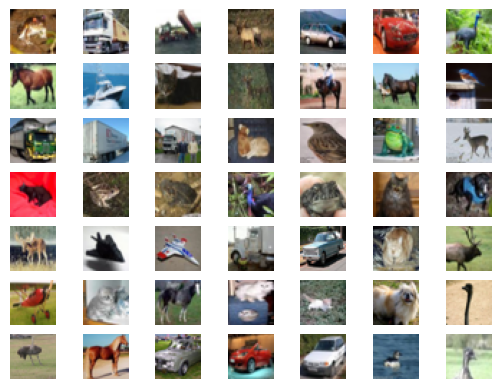

In [4]:
from matplotlib import pyplot
# plot images from the training dataset
for i in range(49):
	# define subplot
	pyplot.subplot(7, 7, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i])
pyplot.show()

# How to Define and Train the Discriminator Model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

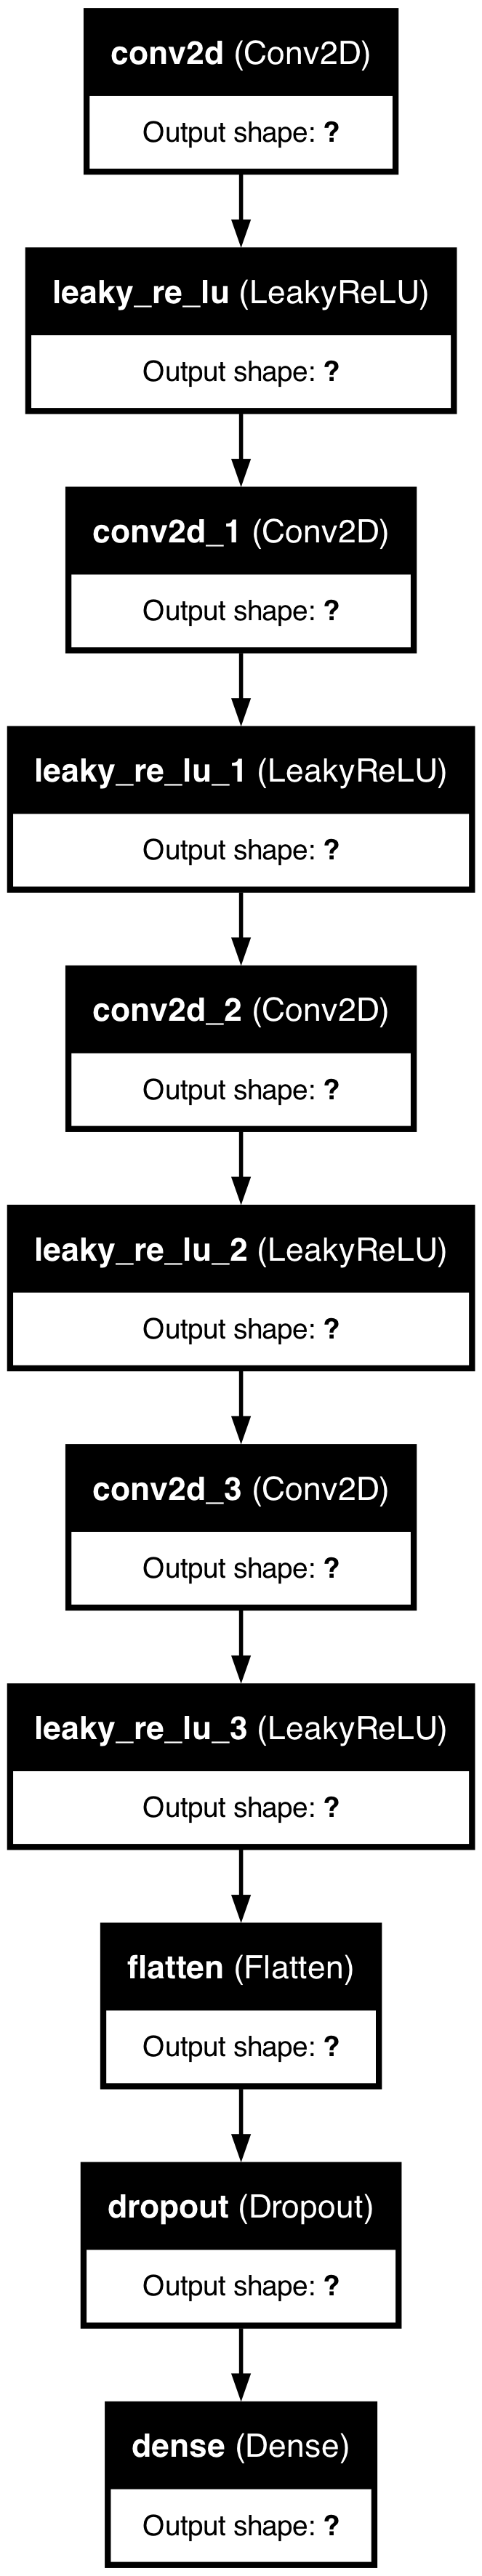

In [5]:
# example of defining the discriminator model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils import plot_model

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same'))
	model.add(LeakyReLU(negative_slope=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(negative_slope=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(negative_slope=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(negative_slope=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define model
model = define_discriminator()
model.build()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='image/discriminator_plot.png', show_shapes=True, show_layer_names=True)

# Train Discriminator

__tanh is the G best practice__

___The generator model will generate images with pixel values in the range [-1,1] as it will use the tanh activation function, a best practice.___

It is also a good practice for the real images to be scaled to the same range.

In [6]:
# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

In [7]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, 1))
	return X, y

In [8]:
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = np.random.rand(32 * 32 * 3 * n_samples)
	# update to have the range [-1, 1]
	X = -1 + X * 2
	# reshape into a batch of color images
	X = X.reshape((n_samples, 32, 32, 3))
	# generate 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

In [9]:
# example of training the discriminator model on real and random cifar10 images
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU



# train the discriminator model
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

>1 real=81% fake=41%
>2 real=60% fake=45%
>3 real=56% fake=48%
>4 real=56% fake=55%
>5 real=59% fake=63%
>6 real=65% fake=68%
>7 real=70% fake=72%
>8 real=74% fake=75%
>9 real=76% fake=77%
>10 real=78% fake=79%
>11 real=79% fake=80%
>12 real=81% fake=82%
>13 real=82% fake=83%
>14 real=83% fake=84%
>15 real=85% fake=85%
>16 real=85% fake=86%
>17 real=86% fake=87%
>18 real=87% fake=88%
>19 real=88% fake=88%
>20 real=88% fake=89%


# How to Define and Use the Generator Model


1. The next major architectural innovation involves __upsampling__ the low-resolution image to a higher resolution version of the image.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

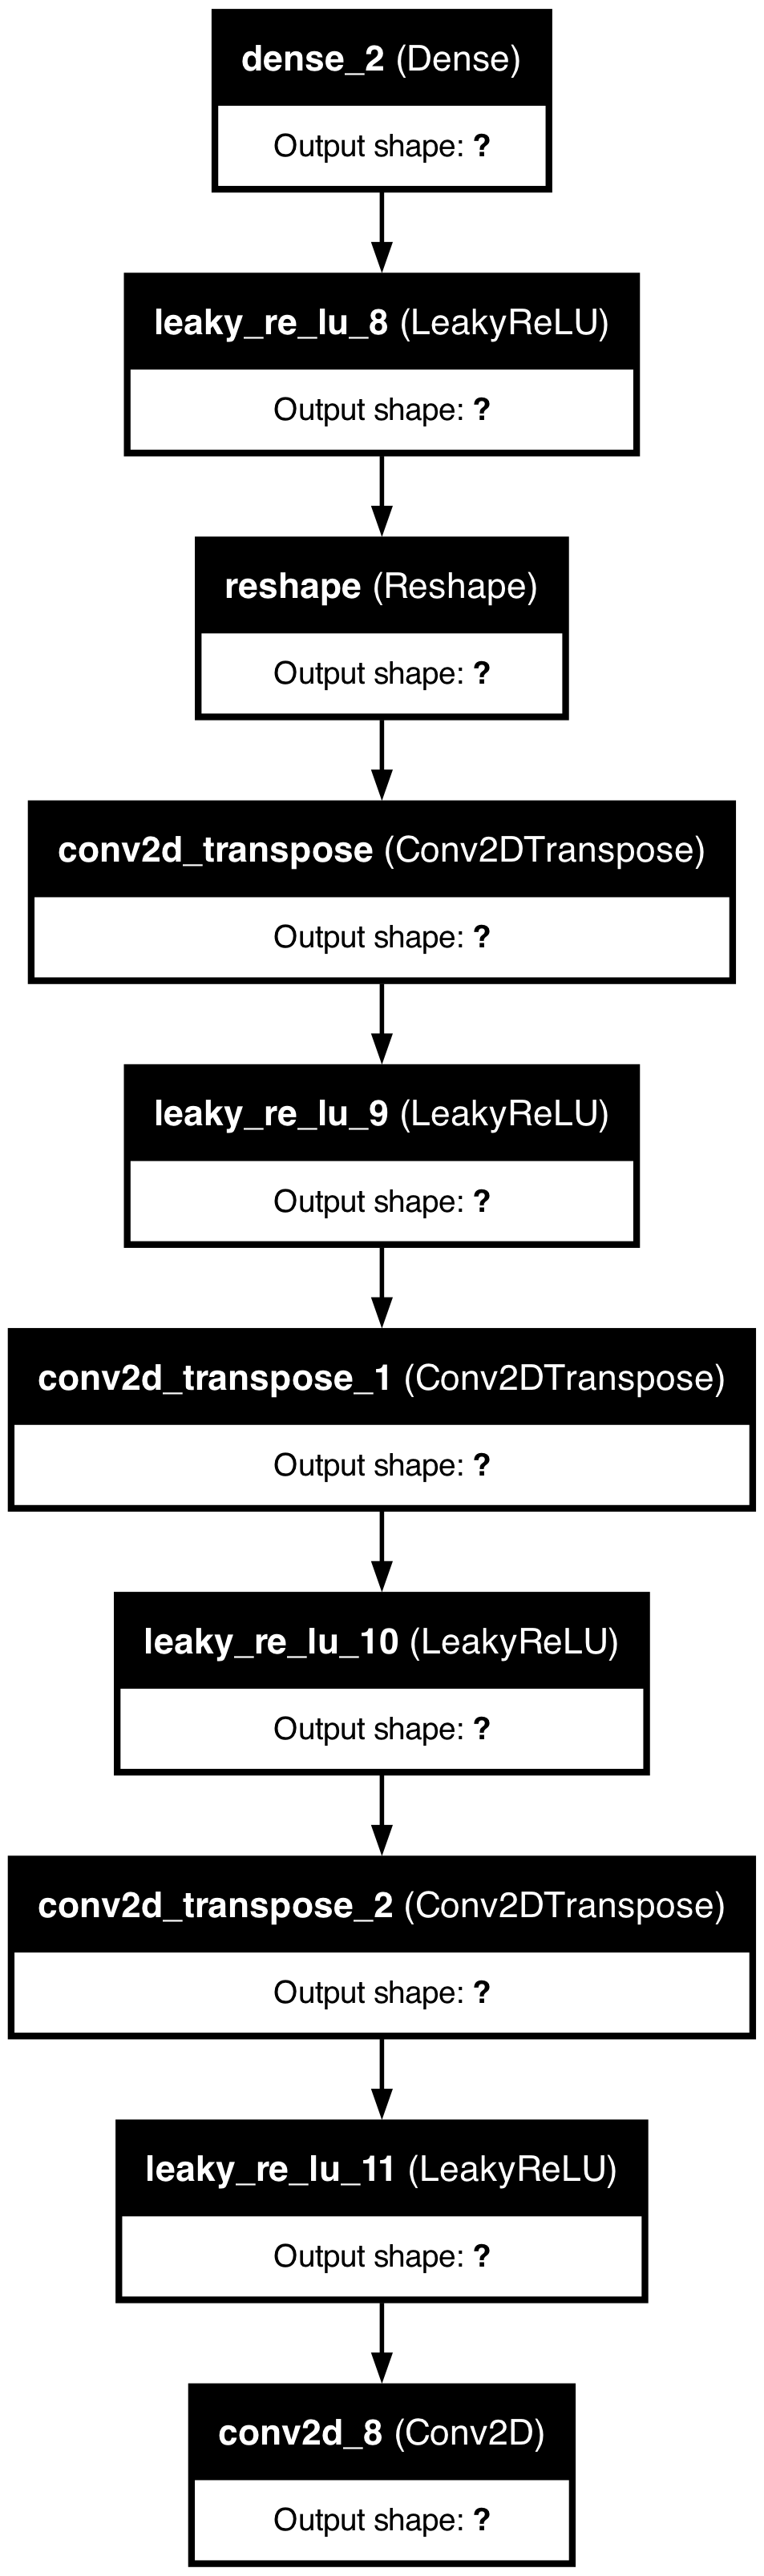

In [10]:
# example of defining the generator model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils import plot_model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes))
	model.add(LeakyReLU(negative_slope=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(negative_slope=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(negative_slope=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(negative_slope=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
model.build()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='image/generator_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [12]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

We can then plot the generated samples as we did the real CIFAR-10 examples in the first section by calling the imshow() function.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 


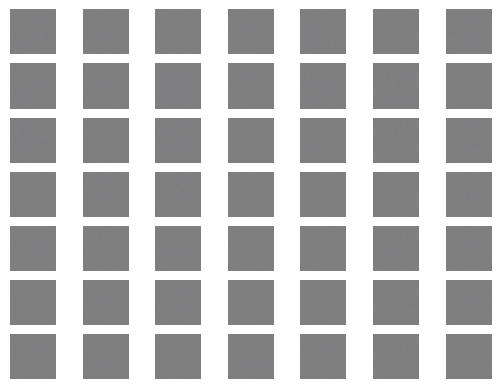

In [13]:
# example of defining and using the generator model
from numpy import zeros
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from matplotlib import pyplot


# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 49
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# scale pixel values from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the generated samples
for i in range(n_samples):
	# define subplot
	pyplot.subplot(7, 7, 1 + i)
	# turn off axis labels
	pyplot.axis('off')
	# plot single image
	pyplot.imshow(X[i])
# show the figure
pyplot.show()

# How to Train the Generator Model

In [97]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_51 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_50 (Sequential)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

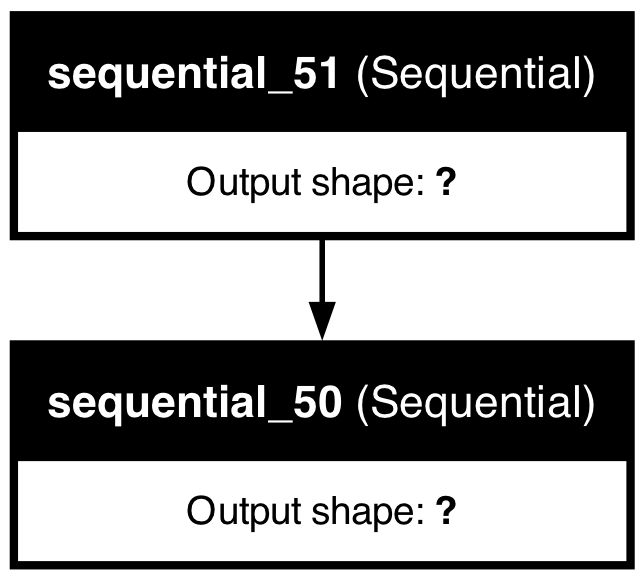

In [98]:
# demonstrate creating the three models in the gan
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.utils import plot_model


# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
gan_model.build()
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='image/gan_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=200, n_batch=128):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

__Complete GAN training process__

Instead, what is required is that we ___first update the discriminator model with real and fake samples, then update the generator via the composite model.___

This requires combining elements from the train_discriminator() function defined in the discriminator section above and the train_gan() function defined above. It also requires that we enumerate over both epochs and batches within in an epoch.

The complete train function for updating the discriminator model and the generator (via the composite model) is listed below.

There are a few things to note in this model training function.

First, the number of batches within an epoch is defined by how many times the batch size divides into the training dataset. We have a dataset size of 50K samples, so with rounding down, there are 390 batches per epoch.

___The discriminator model is updated twice per batch, once with real samples and once with fake samples, which is a best practice as opposed to combining the samples and performing a single update.___

Finally, we report the loss each batch. It is critical to keep an eye on the loss over batches. The reason for this is that a crash in the discriminator loss indicates that the generator model has started generating rubbish examples that the discriminator can easily discriminate.

Monitor the discriminator loss and expect it to hover around 0.5 to 0.8 per batch. The generator loss is less critical and may hover between 0.5 and 2 or higher. A clever programmer might even attempt to detect the crashing loss of the discriminator, halt, and then restart the training process.

# How to Evaluate GAN Model Performance

First, we can define a function called `summarize_performance()` that will summarize the performance of the discriminator model. ___It does this by retrieving a sample of real CIFAR-10 images, as well as generating the same number of fake CIFAR-10 images with the generator model, then evaluating the classification accuracy of the discriminator model on each sample, and reporting these scores.___

In [15]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'image/generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

In [16]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	# filename = 'generator_model_%03d.h5' % (epoch+1)
	# g_model.save(filename)

In [17]:
# train the generator and discriminator
from tqdm import tqdm 
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	min_loss = float("infinity")
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in tqdm(range(n_epochs)):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
			if g_loss < min_loss:
				# print("Model Saved")
				g_model.save("model/generator_model.keras", )
				min_loss = min(g_loss, min_loss)

		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
		
	


# Complete Training of GAN for CIFAR-10

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10)

# Inference

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


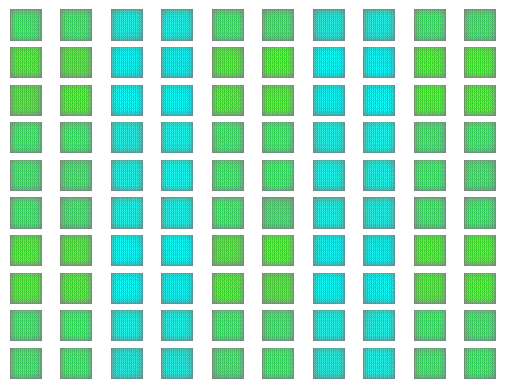

In [18]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
#model = load_model('generator_model_200.h5')
model = load_model('generator_model.keras')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


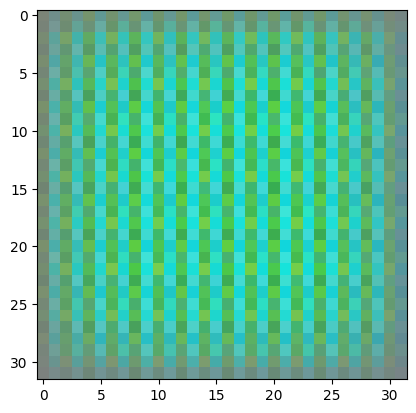

In [19]:
# example of generating an image for a specific point in the latent space
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
# load model
#model = load_model('generator_model_200.h5')
model = load_model('generator_model.keras')
# all 0s
vector = asarray([[0.75 for _ in range(100)]])
# generate image
X = model.predict(vector)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
pyplot.imshow(X[0, :, :])
pyplot.show()